In [ ]:
import warnings
warnings.filterwarnings('ignore')

# ---------------- Core ----------------
import os
import re
import json
import random
from datetime import datetime
from pathlib import Path
from collections import Counter
from concurrent.futures import ProcessPoolExecutor, as_completed

import numpy as np
import pandas as pd

# ---------------- Sklearn / Imbalance ----------------
from sklearn.preprocessing import OneHotEncoder, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier 
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, brier_score_loss, roc_curve
)

from imblearn.over_sampling import SMOTE

# ---------------- Plotting  ----------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
pyo.init_notebook_mode()
plt.style.use('default')
sns.set_palette("husl")

import shap

try:
    from boruta import BorutaPy
    BORUTA_AVAILABLE = True
except ImportError:
    BORUTA_AVAILABLE = False
    print("Boruta not available. Install with: pip install Boruta")

from tqdm.auto import tqdm

from joblib import dump

In [ ]:
# =================================================================================
# Global Config
# =================================================================================
RANDOM_STATE = 42
N_JOBS = max(2, os.cpu_count() or 2)
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
os.environ['PYTHONHASHSEED'] = str(RANDOM_STATE)

VERBOSE = False
def vprint(*args, **kwargs):
    if VERBOSE: print(*args, **kwargs)

print(f"Configuration: Using {N_JOBS} cores for parallel processing")
print("All libraries imported successfully!")

In [ ]:
# =================================================================================
# UTIL: sanitize column names (LightGBM-safe)
# =================================================================================

def sanitize_name(name: str) -> str:
    safe = re.sub(r'[^A-Za-z0-9_]', '_', str(name))
    if safe and safe[0].isdigit():
        safe = f"f_{safe}"
    safe = re.sub(r'__+', '_', safe).strip('_')
    return safe or "f_"

def make_unique_mapping(cols):
    base = [sanitize_name(c) for c in cols]
    counter = Counter()
    mapping, seen = {}, set()
    for raw, b in zip(cols, base):
        name = b
        while name in seen:
            counter[b] += 1
            name = f"{b}__{counter[b]}"
        seen.add(name)
        mapping[raw] = name
    return mapping


In [ ]:
# =================================================================================
# DATASET BUILDER: master_boruta_*
# =================================================================================

class MasterBorutaBuilder:
    def __init__(self, data_path="../data/processed/", k_keep_hint=13, corr_thresh=0.90,
                 include_tentative=False, max_iter=200, alpha=0.05, random_state=42):
        self.data_path = Path(data_path)
        self.k_keep_hint = k_keep_hint
        self.corr_thresh = corr_thresh
        self.include_tentative = include_tentative
        self.max_iter = max_iter
        self.alpha = alpha
        self.random_state = random_state
        
    def _add_engineered_features(self, df):
        df = df.copy()
        cols = set(df.columns)
        if {'chol','age'} <= cols:      df['chol_per_age'] = df['chol'] / (df['age'] + 1e-8)
        if {'trestbps','age'} <= cols:  df['bps_per_age']  = df['trestbps'] / (df['age'] + 1e-8)
        if {'thalach','age'} <= cols:   df['hr_ratio']     = df['thalach']  / (df['age'] + 1e-8)
        if 'age' in cols:
            df['age_bin'] = pd.cut(df['age'], bins=5, labels=False).astype('category')
        return df

    def _get_ohe(self):
        try:
            return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        except TypeError:
            return OneHotEncoder(handle_unknown='ignore', sparse=False)

    def _fit_preprocess(self, X_train, numeric_cols, categorical_cols):
        num_proc = Pipeline([
            ('imp', SimpleImputer(strategy='median')),
            ('sc', RobustScaler())
        ])
        cat_proc = Pipeline([
            ('imp', SimpleImputer(strategy='most_frequent')),
            ('ohe', self._get_ohe())
        ])
        pre = ColumnTransformer([
            ('num', num_proc, numeric_cols),
            ('cat', cat_proc, categorical_cols),
        ], verbose_feature_names_out=False)
        try:
            pre.set_output(transform='pandas')
        except Exception:
            pass

        Xt = pre.fit_transform(X_train)
        if not isinstance(Xt, pd.DataFrame):
            num_cols_out = numeric_cols
            try:
                ohe_cols = list(pre.named_transformers_['cat']['ohe'].get_feature_names_out(categorical_cols))
            except Exception:
                ohe_cols = []
            cols = list(num_cols_out) + list(ohe_cols)
            Xt = pd.DataFrame(Xt, columns=cols, index=X_train.index)
        return pre, Xt

    def _transform(self, pre, X, numeric_cols, categorical_cols):
        Xt = pre.transform(X)
        if not isinstance(Xt, pd.DataFrame):
            num_cols_out = numeric_cols
            try:
                ohe_cols = list(pre.named_transformers_['cat']['ohe'].get_feature_names_out(categorical_cols))
            except Exception:
                ohe_cols = []
            cols = list(num_cols_out) + list(ohe_cols)
            Xt = pd.DataFrame(Xt, columns=cols, index=X.index)
        return Xt

    def _variance_threshold(self, X, thresh=0.0):
        vt = VarianceThreshold(thresh)
        Xo = pd.DataFrame(vt.fit_transform(X), columns=vt.get_feature_names_out(), index=X.index)
        return Xo, vt

    def _corr_prune(self, X, threshold):
        num_cols = X.select_dtypes(include=[np.number]).columns
        if len(num_cols) <= 1:
            return X
        Xn = X[num_cols].copy()
        corr = Xn.corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        drop = [col for col in upper.columns if any(upper[col] > threshold)]
        return X.drop(columns=drop, errors='ignore')

    def _mild_polynomial(self, pre, X_raw, numeric_cols):
        if len(numeric_cols) == 0:
            return pd.DataFrame(index=X_raw.index)
        poly = PolynomialFeatures(degree=2, include_bias=False)
        num_pipe = pre.named_transformers_['num']
        Xnum = num_pipe.transform(X_raw[numeric_cols])

        P = poly.fit_transform(Xnum)
        names = poly.get_feature_names_out(numeric_cols)
        sq_mask = np.array([("^2" in n) or (" " not in n) for n in names])
        P = P[:, sq_mask]
        pcols = [n for n, m in zip(names, sq_mask) if m]
        P_df = pd.DataFrame(P, columns=[f"poly:{c}" for c in pcols], index=X_raw.index)
        return P_df

    def _load_raw(self):
        tr = pd.read_csv(self.data_path / 'raw_train.csv')
        va = pd.read_csv(self.data_path / 'raw_val.csv')
        te = pd.read_csv(self.data_path / 'raw_test.csv')
        return tr, va, te

    def build_and_save(self):
        if not BORUTA_AVAILABLE:
            raise ImportError("Boruta not available. Install with: pip install Boruta")

        tr, va, te = self._load_raw()
        feat_cols = [c for c in tr.columns if c != 'target']
        y_tr, y_va, y_te = tr['target'], va['target'], te['target']
        X_tr0, X_va0, X_te0 = tr[feat_cols], va[feat_cols], te[feat_cols]

        # FE 
        X_tr = self._add_engineered_features(X_tr0)
        X_va = self._add_engineered_features(X_va0)
        X_te = self._add_engineered_features(X_te0)

        # loại & OHE
        numeric_cols = list(X_tr.select_dtypes(include=[np.number]).columns)
        categorical_cols = [c for c in X_tr.columns if c not in numeric_cols]

        pre, Xt_tr = self._fit_preprocess(X_tr, numeric_cols, categorical_cols)
        Xt_va = self._transform(pre, X_va, numeric_cols, categorical_cols)
        Xt_te = self._transform(pre, X_te, numeric_cols, categorical_cols)

        # VT
        Xt_tr, vt = self._variance_threshold(Xt_tr, 0.0)
        Xt_va = pd.DataFrame(vt.transform(Xt_va), columns=vt.get_feature_names_out(), index=X_va.index)
        Xt_te = pd.DataFrame(vt.transform(Xt_te), columns=vt.get_feature_names_out(), index=X_te.index)

        # Corr-prune
        Xt_tr = self._corr_prune(Xt_tr, self.corr_thresh)
        keep_cols = Xt_tr.columns
        Xt_va = Xt_va.reindex(columns=keep_cols, fill_value=0)
        Xt_te = Xt_te.reindex(columns=keep_cols, fill_value=0)

        # Mild poly  
        P_tr = self._mild_polynomial(pre, X_tr, numeric_cols)
        P_va = self._mild_polynomial(pre, X_va, numeric_cols)  
        P_te = self._mild_polynomial(pre, X_te, numeric_cols) 

        Xt_tr = pd.concat([Xt_tr, P_tr], axis=1)
        Xt_va = pd.concat([Xt_va, P_va], axis=1).reindex(columns=Xt_tr.columns, fill_value=0)
        Xt_te = pd.concat([Xt_te, P_te], axis=1).reindex(columns=Xt_tr.columns, fill_value=0)

        # Reduce sơ bộ trước Boruta (nhanh hơn)
        k = min(self.k_keep_hint*3, Xt_tr.shape[1]) if Xt_tr.shape[1] > 0 else 0
        if k > 0:
            skb = SelectKBest(score_func=f_classif, k=k)
            skb.fit(Xt_tr, y_tr)
            sel_cols_pre = Xt_tr.columns[skb.get_support()]
            Xt_tr = Xt_tr[sel_cols_pre]
            Xt_va = Xt_va[sel_cols_pre]
            Xt_te = Xt_te[sel_cols_pre]

        # Boruta trên (train+val)
        comb = pd.concat([Xt_tr, Xt_va], axis=0, ignore_index=True)
        y_comb = pd.concat([y_tr, y_va], axis=0, ignore_index=True)

        rf = RandomForestClassifier(
            n_estimators=300, random_state=self.random_state, n_jobs=1, max_depth=None
        )
        boruta = BorutaPy(
            estimator=rf,
            n_estimators='auto',
            max_iter=self.max_iter,
            alpha=self.alpha,
            random_state=self.random_state
        )
        boruta.fit(comb.values, y_comb.values)

        mask = boruta.support_ | (boruta.support_weak_ if self.include_tentative else False)
        selected_cols = [col for col, keep in zip(comb.columns, mask) if keep]
        if len(selected_cols) == 0:
            selected_cols = list(Xt_tr.columns) 

        # Sanitize tên cột (LightGBM-safe) + mapping
        rename_map = make_unique_mapping(selected_cols)

        MB_tr = Xt_tr[selected_cols].rename(columns=rename_map).assign(target=y_tr.values)
        MB_va = Xt_va[selected_cols].rename(columns=rename_map).assign(target=y_va.values)
        MB_te = Xt_te[selected_cols].rename(columns=rename_map).assign(target=y_te.values)

        MB_tr.to_csv(self.data_path / 'master_boruta_train.csv', index=False)
        MB_va.to_csv(self.data_path / 'master_boruta_val.csv', index=False)
        MB_te.to_csv(self.data_path / 'master_boruta_test.csv', index=False)

        print(f"✓ Built and saved: master_boruta_* with {len(rename_map)} features")
        return list(rename_map.values())


In [ ]:
# =================================================================================
# DATA LOADER
# =================================================================================

class DataManager:
    def __init__(self, data_path="../data/processed/"):
        self.data_path = Path(data_path)
        self.datasets = {}
        self.feature_names = {}

    def _safe_read(self, path):
        df = pd.read_csv(path)
        cols = [c for c in df.columns if c != 'target']
        mapping = make_unique_mapping(cols)
        df = df.rename(columns=mapping)
        return df

    def load_all_datasets(self):
        dataset_files = {
            'raw':           ['raw_train.csv',        'raw_val.csv',        'raw_test.csv'],
            'fe':            ['fe_train.csv',         'fe_val.csv',         'fe_test.csv'],
            'dt':            ['dt_train.csv',         'dt_val.csv',         'dt_test.csv'],
            'fe_dt':         ['fe_dt_train.csv',      'fe_dt_val.csv',      'fe_dt_test.csv'],
            'master_boruta': ['master_boruta_train.csv','master_boruta_val.csv','master_boruta_test.csv'],
        }

        for name, files in dataset_files.items():
            try:
                tr = self._safe_read(self.data_path / files[0])
                va = self._safe_read(self.data_path / files[1])
                te = self._safe_read(self.data_path / files[2])
                self.datasets[name] = {'train': tr, 'val': va, 'test': te}
                self.feature_names[name] = [c for c in tr.columns if c != 'target']
                print(f"✓ Loaded {name} dataset - Train: {tr.shape}, Val: {va.shape}, Test: {te.shape}")
            except FileNotFoundError:
                pass  
        return self.datasets

    def get_combined_data(self, dataset_name):
        if dataset_name not in self.datasets:
            raise ValueError(f"Dataset {dataset_name} not found")
        tr = self.datasets[dataset_name]['train']
        va = self.datasets[dataset_name]['val']
        te = self.datasets[dataset_name]['test']
        comb = pd.concat([tr, va], ignore_index=True)
        X_combined = comb.drop('target', axis=1)
        y_combined = comb['target']
        X_test = te.drop('target', axis=1)
        y_test = te['target']
        return X_combined, y_combined, X_test, y_test

In [ ]:

# =================================================================================
# TRAINING with Hyperparameter Tuning
# =================================================================================

class ImbalanceHandler:
    def __init__(self, random_state=42):
        self.random_state = random_state
        self.techniques = {
            'none': None,
            'smote': SMOTE(random_state=random_state),
        }
    def apply(self, X, y, technique='smote'):
        if technique == 'none':
            return X, y
        tech = self.techniques.get(technique)
        if tech is None:
            return X, y
        try:
            return tech.fit_resample(X, y)
        except Exception as e:
            vprint(f"[{technique}] fallback to 'none' due to: {e}")
            return X, y

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from sklearn.model_selection import StratifiedKFold

class EnhancedModelTrainer:
    """
    Optuna-based hyperparameter tuner with per-model search spaces.
    - Runs entirely in-process (n_jobs=1 for estimators) to avoid nested parallelism.
    - Uses StratifiedKFold CV.
    - Scoring: 'f1' (default) or 'roc_auc'.
    """
    def __init__(self, random_state=42, cv_folds=3, scoring='f1'):
        self.random_state = random_state
        self.cv_folds = cv_folds
        assert scoring in ('f1', 'roc_auc')
        self.scoring = scoring
        self.direction = 'maximize'

    # ---------- Base estimators ----------
    def get_base_models(self):
        return {
            'logistic': LogisticRegression(random_state=self.random_state, max_iter=2000, n_jobs=1),
            'rf':       RandomForestClassifier(random_state=self.random_state, n_jobs=1),
            'xgb':      XGBClassifier(random_state=self.random_state, verbosity=0, n_jobs=1, tree_method='hist', eval_metric='logloss'),
            'lgbm':     LGBMClassifier(random_state=self.random_state, verbosity=-1, n_jobs=1),
            'ada':      AdaBoostClassifier(random_state=self.random_state),
            'gb':       GradientBoostingClassifier(random_state=self.random_state),
            'svm':      SVC(probability=True),
            'knn':      KNeighborsClassifier()
        }

    # ---------- Search spaces ----------
    def _suggest_params(self, trial, model_name):
        if model_name == 'logistic':
            return dict(
                C=trial.suggest_float('C', 1e-3, 1e+2, log=True),
                penalty=trial.suggest_categorical('penalty', ['l2']),  # liblinear/lbfgs both ok for l2
                solver=trial.suggest_categorical('solver', ['liblinear', 'lbfgs']),
                class_weight=trial.suggest_categorical('class_weight', [None, 'balanced']),
                max_iter=2000
            )

        if model_name == 'rf':
            return dict(
                n_estimators=trial.suggest_int('n_estimators', 200, 1000, step=100),
                max_depth=trial.suggest_int('max_depth', 3, 32) if trial.suggest_categorical('use_max_depth', [True, False]) else None,
                min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
                min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 8),
                max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5]),
                class_weight=trial.suggest_categorical('class_weight', [None, 'balanced'])
            )


        if model_name == 'xgb':
            return dict(
                n_estimators=trial.suggest_int('n_estimators', 200, 1000, step=100),
                max_depth=trial.suggest_int('max_depth', 3, 10),
                learning_rate=trial.suggest_float('learning_rate', 1e-3, 3e-1, log=True),
                subsample=trial.suggest_float('subsample', 0.6, 1.0),
                colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
                reg_lambda=trial.suggest_float('reg_lambda', 0.0, 10.0),
            )

        if model_name == 'lgbm':
            return dict(
                n_estimators=trial.suggest_int('n_estimators', 200, 1000, step=100),
                num_leaves=trial.suggest_int('num_leaves', 15, 255),
                max_depth=trial.suggest_int('max_depth', 3, 16) if trial.suggest_categorical('use_max_depth', [True, False]) else -1,
                learning_rate=trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
                subsample=trial.suggest_float('subsample', 0.6, 1.0),
                colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
                reg_lambda=trial.suggest_float('reg_lambda', 0.0, 10.0)
            )

        if model_name == 'ada':
            return dict(
                n_estimators=trial.suggest_int('n_estimators', 100, 1000, step=100),
                learning_rate=trial.suggest_float('learning_rate', 1e-3, 1.0, log=True),
                algorithm=trial.suggest_categorical('algorithm', ['SAMME'])
            )

        if model_name == 'gb':
            return dict(
                n_estimators=trial.suggest_int('n_estimators', 100, 1000, step=100),
                max_depth=trial.suggest_int('max_depth', 2, 8),
                learning_rate=trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
                subsample=trial.suggest_float('subsample', 0.6, 1.0)
            )

        if model_name == 'svm':
            kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
            params = dict(
                C=trial.suggest_float('C', 1e-2, 1e+2, log=True),
                kernel=kernel,
                probability=True
            )
            if kernel == 'rbf':
                params['gamma'] = trial.suggest_categorical('gamma', ['scale', 'auto'])
            return params

        if model_name == 'knn':
            return dict(
                n_neighbors=trial.suggest_int('n_neighbors', 3, 31, step=2),
                weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
                p=trial.suggest_categorical('p', [1, 2])  # 1=manhattan, 2=euclidean
            )

        raise ValueError(f"Unknown model_name: {model_name}")

    def _cv_score(self, est, X, y):
        cv = StratifiedKFold(n_splits=self.cv_folds, shuffle=True, random_state=self.random_state)
        scores = []
        for tr_idx, va_idx in cv.split(X, y):
            Xtr, Xva = X.iloc[tr_idx], X.iloc[va_idx]
            ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
            est.fit(Xtr, ytr)
            if self.scoring == 'roc_auc':
                if hasattr(est, 'predict_proba'):
                    proba = est.predict_proba(Xva)[:, 1]
                    scores.append(roc_auc_score(yva, proba))
                else:
                    # fallback if no proba
                    preds = est.decision_function(Xva) if hasattr(est, 'decision_function') else est.predict(Xva)
                    # Roc AUC needs scores; if only labels exist, skip (very rare in our set)
                    try:
                        scores.append(roc_auc_score(yva, preds))
                    except:
                        pass
            else:  # f1
                preds = est.predict(Xva)
                scores.append(f1_score(yva, preds, zero_division=0))
        return float(np.mean(scores)) if scores else 0.0

    # ---------- Optuna objective ----------
    def _make_objective(self, model_name, base_estimator, X, y):
        def objective(trial):
            params = self._suggest_params(trial, model_name)
            est = base_estimator.__class__(**{**base_estimator.get_params(), **params})
            score = self._cv_score(est, X, y)
            return score
        return objective

    def _optimize_model(self, model_name, base_estimator, X, y, n_trials=30, timeout=None):
        sampler = TPESampler(seed=self.random_state)
        pruner = MedianPruner(n_warmup_steps=max(5, n_trials // 5))
        study = optuna.create_study(direction=self.direction, sampler=sampler, pruner=pruner)
        study.optimize(self._make_objective(model_name, base_estimator, X, y),
                       n_trials=n_trials, timeout=timeout, show_progress_bar=False)
        return study

    # ---------- External API used by pipeline ----------
    def get_models_with_tuning(self, n_iter=50):
        """
        For compatibility with pipeline:
        - returns dict[name] = ("optuna", base_estimator, n_trials)
        """
        base = self.get_base_models()
        tuned = {}
        for name, est in base.items():
            tuned[name] = ("optuna", est, n_iter)
        return tuned

    def train_single_with_tuning(self, cfg):
        """
        Runs Optuna for one (dataset,imbalance,model).
        Returns the fitted best_estimator_ and test metrics.
        """
        config_name, model, Xtr, ytr, Xte, yte = cfg
        model_name = config_name.split('_')[-1]
        mode_tag, base_estimator, n_trials = ("optuna", model, 50) if not isinstance(model, tuple) else model
        try:
            # 1) Optimize on (Xtr,ytr)
            study = self._optimize_model(model_name, base_estimator, Xtr, ytr, n_trials=n_trials)

            # 2) Refit best estimator on all training data
            best_params = study.best_params
            best_estimator = base_estimator.__class__(**{**base_estimator.get_params(), **best_params})
            best_estimator.fit(Xtr, ytr)

            # 3) Evaluate on test
            y_pred = best_estimator.predict(Xte)
            y_proba = best_estimator.predict_proba(Xte)[:, 1] if hasattr(best_estimator, 'predict_proba') else None
            metrics = {
                'accuracy': accuracy_score(yte, y_pred),
                'precision': precision_score(yte, y_pred, zero_division=0),
                'recall': recall_score(yte, y_pred, zero_division=0),
                'f1': f1_score(yte, y_pred, zero_division=0),
                'specificity': recall_score(yte, y_pred, pos_label=0, zero_division=0)
            }
            if y_proba is not None and len(np.unique(yte)) > 1:
                metrics['roc_auc'] = roc_auc_score(yte, y_proba)

            return {
                'model_name': model_name,
                'metrics': metrics,
                'y_true': yte,
                'y_pred': y_pred,
                'y_proba': y_proba,
                'status': 'success',
                'fitted_model': best_estimator,
                'best_params': best_params,
                'best_value': study.best_value,
                'best_trial': study.best_trial.number
            }
        except Exception as e:
            return {'model_name': model_name, 'error': str(e), 'status': 'error'}


In [ ]:
# =================================================================================
# VIS & CLINICAL
# =================================================================================

class Visualizer:
    def __init__(self):
        self.colors = px.colors.qualitative.Set3
    def heatmap(self, df, metric='f1'):
        if df.empty: return
        pv = df.pivot_table(index=['Dataset'], columns=['Model'], values=metric, aggfunc='mean').fillna(0)
        fig = go.Figure(data=go.Heatmap(z=pv.values, x=pv.columns, y=pv.index, colorscale='Viridis',
                                        text=np.round(pv.values,3), texttemplate="%{text}", textfont={"size":10}))
        fig.update_layout(title=f'Performance Heatmap - {metric.upper()}', xaxis_title='Models', yaxis_title='Dataset', height=400, width=800)
        fig.show()
    def top_bars(self, df, top_n=8):
        if df.empty: return
        top = df.nlargest(top_n, 'f1').copy()
        top['config'] = top['Dataset'] + '_' + top['Model']
        fig = make_subplots(rows=2, cols=2, subplot_titles=('F1','Accuracy','Precision','Recall'))
        metrics = [('f1',1,1),('accuracy',1,2),('precision',2,1),('recall',2,2)]
        for m,r,c in metrics:
            fig.add_trace(go.Bar(x=top['config'], y=top[m], name=m), row=r, col=c)
        fig.update_layout(height=600, width=1000, showlegend=False)
        fig.update_xaxes(tickangle=45)
        fig.show()

class ClinicalValidator:
    def metrics(self, y_true, y_pred, y_proba=None):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        out = {
            'sensitivity': tp/(tp+fn) if (tp+fn)>0 else 0,
            'specificity': tn/(tn+fp) if (tn+fp)>0 else 0,
            'ppv': tp/(tp+fp) if (tp+fp)>0 else 0,
            'npv': tn/(tn+fn) if (tn+fn)>0 else 0,
            'balanced_accuracy': ((tp/(tp+fn) if (tp+fn)>0 else 0) + (tn/(tn+fp) if (tn+fp)>0 else 0))/2
        }
        if y_proba is not None and len(np.unique(y_true))>1:
            try: out['brier_score'] = brier_score_loss(y_true, y_proba)
            except: pass
        return out

In [ ]:

# =================================================================================
# PIPELINE (with hyperparam tuning, saving models & SHAP packs)
# =================================================================================

class HeartDiseasePipeline:
    def __init__(self, data_path="../data/processed/", random_state=42, n_jobs=N_JOBS):
        self.data_path = data_path
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.dm   = DataManager(data_path)
        self.imb  = ImbalanceHandler(random_state)
        self.tuner= EnhancedModelTrainer(random_state)
        self.vis  = Visualizer()
        self.clin = ClinicalValidator()
        self.results = {}
        self.summary_df = pd.DataFrame()

        Path("./models").mkdir(exist_ok=True)
        Path("./artifacts").mkdir(exist_ok=True)

    def _prepare(self, dataset_name, imbalance):
        Xc, yc, Xte, yte = self.dm.get_combined_data(dataset_name)
        Xtr, ytr = self.imb.apply(Xc, yc, imbalance)
        return Xtr, ytr, Xte, yte

    def _train_config(self, dataset_name, imbalance, n_iter=50):
        Xtr, ytr, Xte, yte = self._prepare(dataset_name, imbalance)
        models = self.tuner.get_models_with_tuning(n_iter=n_iter)
        cfgs = [(f"{dataset_name}_{imbalance}_{m}", mdl, Xtr, ytr, Xte, yte) for m, mdl in models.items()]

        res = {}
        with ProcessPoolExecutor(max_workers=min(self.n_jobs, len(cfgs))) as ex:
            futs = {ex.submit(self.tuner.train_single_with_tuning, cfg): cfg[0] for cfg in cfgs}
            for fut in tqdm(as_completed(futs), total=len(futs), leave=False, desc=f"Training {dataset_name}/{imbalance}"):
                key = futs[fut]
                try: res[key] = fut.result()
                except Exception as e: res[key] = {'status':'error','error':str(e)}
        return res

    def run(self, datasets=('raw','fe','dt','fe_dt','master_boruta'), imbalance=('none','smote'), n_iter=50):
        print("Starting Pipeline with Hyperparameter Tuning")
        self.dm.load_all_datasets()
        combos = [(ds, imb) for ds in datasets if ds in self.dm.datasets for imb in imbalance]
        print(f"Testing {len(combos)} dataset/imbalance combinations × {8} models each...")

        all_res = {}
        for ds, imb in tqdm(combos, desc="Configs"):
            all_res.update(self._train_config(ds, imb, n_iter=n_iter))
        self.results = all_res
        self._summarize()
        return all_res

    def _summarize(self):
        rows = []
        for cfg, r in self.results.items():
            if r.get('status') == 'success':
                parts = cfg.split('_')
                dataset = '_'.join(parts[:-2]) if len(parts)>2 else parts[0]
                imb = parts[-2] if len(parts)>2 else 'none'
                model = parts[-1]
                row = {'Configuration': cfg, 'Dataset': dataset, 'Imbalance': imb, 'Model': model, **r['metrics']}
                if 'roc_auc' not in row: row['roc_auc'] = np.nan
                rows.append(row)
        self.summary_df = pd.DataFrame(rows)
        if not self.summary_df.empty:
            self.summary_df = self.summary_df.sort_values('f1', ascending=False)
            print("\n" + "="*80)
            print("TOP 10 CONFIGURATIONS")
            print("="*80)
            cols = ['Configuration','Dataset','Imbalance','Model','f1','accuracy','precision','recall','roc_auc']
            print(self.summary_df.head(10)[cols].round(4).to_string(index=False))

            # Clinical summary (top-10)
            clinical_rows = []
            for cfg, r in self.results.items():
                if r.get('status') == 'success':
                    cm = self.clin.metrics(r['y_true'], r['y_pred'], r.get('y_proba'))
                    clinical_rows.append({'Configuration': cfg, **cm})
            if clinical_rows:
                clin_df = pd.DataFrame(clinical_rows).sort_values('balanced_accuracy', ascending=False)
                print("\n" + "="*80)
                print("TOP 10 CLINICAL PERFORMANCE")
                print("="*80)
                print(clin_df.head(10).round(4).to_string(index=False))

            # Save summaries
            self.summary_df.to_csv('all_datasets_tuned_results.csv', index=False)
            if clinical_rows:
                pd.DataFrame(clinical_rows).to_csv('all_datasets_tuned_clinical.csv', index=False)
            print("\nResults saved to all_datasets_tuned_results.csv")

    # ---------- SAVE BEST MODELS & SHAP PACKS ----------
    def _save_shap_pack(self, dataset_name, imbalance, model_name, fitted_model, Xc, yc, Xte, yte, prefix="best"):
        ts = datetime.now().strftime("%Y%m%d_%H%M%S")
        tag = f"{prefix}_{dataset_name}_{imbalance}_{model_name}_{ts}"
        model_path = f"./models/{tag}.joblib"
        meta_path  = f"./models/{tag}.json"

        # Save model
        dump(fitted_model, model_path)

        # Background sample for SHAP
        bg_n = min(100, Xc.shape[0])
        bg_idx = np.random.choice(np.arange(Xc.shape[0]), size=bg_n, replace=False)
        X_bg = Xc.iloc[bg_idx].copy()

        # Save artifacts
        X_bg.to_csv(f"./artifacts/{tag}_X_background.csv", index=False)
        Xte.to_csv(f"./artifacts/{tag}_X_test.csv", index=False)
        pd.Series(yte).to_csv(f"./artifacts/{tag}_y_test.csv", index=False, header=['target'])

        # Predictions on test for record
        try:
            y_pred = fitted_model.predict(Xte)
            y_proba = fitted_model.predict_proba(Xte)[:,1] if hasattr(fitted_model, 'predict_proba') else None
        except Exception:
            y_pred, y_proba = None, None

        out_pred = pd.DataFrame({'y_true':np.array(yte)})
        if y_pred is not None: out_pred['y_pred'] = y_pred
        if y_proba is not None: out_pred['y_proba'] = y_proba
        out_pred.to_csv(f"./artifacts/{tag}_predictions.csv", index=False)

        meta = {
            "dataset": dataset_name,
            "imbalance": imbalance,
            "model": model_name,
            "features": list(Xc.columns),
            "train_rows": int(Xc.shape[0]),
            "test_rows": int(Xte.shape[0]),
            "paths": {
                "model": model_path,
                "X_background": f"./artifacts/{tag}_X_background.csv",
                "X_test": f"./artifacts/{tag}_X_test.csv",
                "y_test": f"./artifacts/{tag}_y_test.csv",
                "predictions": f"./artifacts/{tag}_predictions.csv"
            }
        }
        with open(meta_path, "w") as f:
            json.dump(meta, f, indent=2)
        print(f"✓ Saved model & SHAP pack → {model_path}")

    def save_best_models(self, per_dataset=True, global_best=True):
        if self.summary_df.empty:
            print("No results to save.")
            return

        res = self.results

        # Global best
        if global_best:
            best_row = self.summary_df.iloc[0]
            cfg = best_row['Configuration']
            ds, imb, mdl = best_row['Dataset'], best_row['Imbalance'], best_row['Model']
            r = res[cfg]
            Xc, yc, Xte, yte = self.dm.get_combined_data(ds)
            if imb != 'none':
                Xc, yc = self.imb.apply(Xc, yc, imb)
            self._save_shap_pack(ds, imb, mdl, r['fitted_model'], Xc, yc, Xte, yte, prefix="global_best")

        # Per-dataset best
        if per_dataset:
            for ds in self.summary_df['Dataset'].unique():
                sub = self.summary_df[self.summary_df['Dataset']==ds].sort_values('f1', ascending=False)
                if sub.empty: continue
                row = sub.iloc[0]
                cfg = row['Configuration']
                imb, mdl = row['Imbalance'], row['Model']
                r = res[cfg]
                Xc, yc, Xte, yte = self.dm.get_combined_data(ds)
                if imb != 'none':
                    Xc, yc = self.imb.apply(Xc, yc, imb)
                self._save_shap_pack(ds, imb, mdl, r['fitted_model'], Xc, yc, Xte, yte, prefix="dataset_best")

In [ ]:

# =================================================================================
# VIS HELPERS
# =================================================================================

def create_visualizations(pipeline):
    if pipeline.summary_df.empty:
        print("No results to visualize")
        return
    print("\nCreating visualizations...")
    pipeline.vis.heatmap(pipeline.summary_df, 'f1')
    pipeline.vis.top_bars(pipeline.summary_df, top_n=8)

def create_roc_comparison(pipeline):
    if pipeline.summary_df.empty: return
    top = pipeline.summary_df.head(5)['Configuration'].tolist()
    plt.figure(figsize=(10,8))
    for cfg in top:
        r = pipeline.results.get(cfg, {})
        if r.get('status')=='success' and r.get('y_proba') is not None:
            try:
                fpr, tpr, _ = roc_curve(r['y_true'], r['y_proba'])
                auc = roc_auc_score(r['y_true'], r['y_proba'])
                plt.plot(fpr, tpr, label=f"{cfg.split('_')[-1]} (AUC={auc:.3f})", linewidth=2)
            except: pass
    plt.plot([0,1],[0,1],'k--',alpha=0.6,label='Random')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves - Top 5')
    plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

Configuration: Using 12 cores for parallel processing
All libraries imported successfully!
Building ONE dataset with engineered features + Boruta selection → master_boruta_*
✓ Built and saved: master_boruta_* with 12 features

Running training on all datasets (with tuning)
Starting Pipeline with Hyperparameter Tuning
✓ Loaded raw dataset - Train: (242, 14), Val: (30, 14), Test: (31, 14)
✓ Loaded fe dataset - Train: (242, 14), Val: (30, 14), Test: (31, 14)
✓ Loaded dt dataset - Train: (242, 11), Val: (30, 11), Test: (31, 11)
✓ Loaded fe_dt dataset - Train: (242, 11), Val: (30, 11), Test: (31, 11)
✓ Loaded master_boruta dataset - Train: (242, 13), Val: (30, 13), Test: (31, 13)
Testing 10 dataset/imbalance combinations × 8 models each...


Configs:   0%|          | 0/10 [00:00<?, ?it/s][I 2025-09-26 21:50:23,327] A new study created in memory with name: no-name-927cc459-311f-40ff-8d02-79ea25ec4898
[I 2025-09-26 21:50:23,328] A new study created in memory with name: no-name-3b5a23e0-b505-46db-80f3-275d86a90c83
[I 2025-09-26 21:50:23,329] A new study created in memory with name: no-name-b71273a7-8257-446f-ab5c-eaecbe7d525d
[I 2025-09-26 21:50:23,330] A new study created in memory with name: no-name-06c17d26-8613-4b56-ba41-7e512a13c726
[I 2025-09-26 21:50:23,331] A new study created in memory with name: no-name-98939e9e-fadb-4678-b9b3-ef259da8a771
[I 2025-09-26 21:50:23,332] A new study created in memory with name: no-name-3d8ad078-796c-4020-8fc2-8a7f948b9519
[I 2025-09-26 21:50:23,337] A new study created in memory with name: no-name-1ebf52cf-8f94-4570-afe1-36060c7a673e
[I 2025-09-26 21:50:23,338] A new study created in memory with name: no-name-132c8fb5-085c-4962-9e9f-b1fd75ed8af9
[I 2025-09-26 21:50:23,388] Trial 0 finis


TOP 10 CONFIGURATIONS
  Configuration Dataset Imbalance Model     f1  accuracy  precision  recall  roc_auc
   raw_none_xgb     raw      none   xgb 0.8571    0.8710     0.8571  0.8571   0.9076
   raw_none_ada     raw      none   ada 0.8571    0.8710     0.8571  0.8571   0.9580
 fe_dt_none_knn   fe_dt      none   knn 0.8571    0.8710     0.8571  0.8571   0.9580
   fe_smote_xgb      fe     smote   xgb 0.8571    0.8710     0.8571  0.8571   0.9370
    fe_none_svm      fe      none   svm 0.8571    0.8710     0.8571  0.8571   0.9328
   raw_smote_gb     raw     smote    gb 0.8571    0.8710     0.8571  0.8571   0.9160
 fe_dt_none_xgb   fe_dt      none   xgb 0.8571    0.8710     0.8571  0.8571   0.9244
  raw_smote_knn     raw     smote   knn 0.8387    0.8387     0.7647  0.9286   0.9013
fe_dt_smote_xgb   fe_dt     smote   xgb 0.8276    0.8387     0.8000  0.8571   0.9202
   raw_none_knn     raw      none   knn 0.8276    0.8387     0.8000  0.8571   0.9202

TOP 10 CLINICAL PERFORMANCE
  Configurati

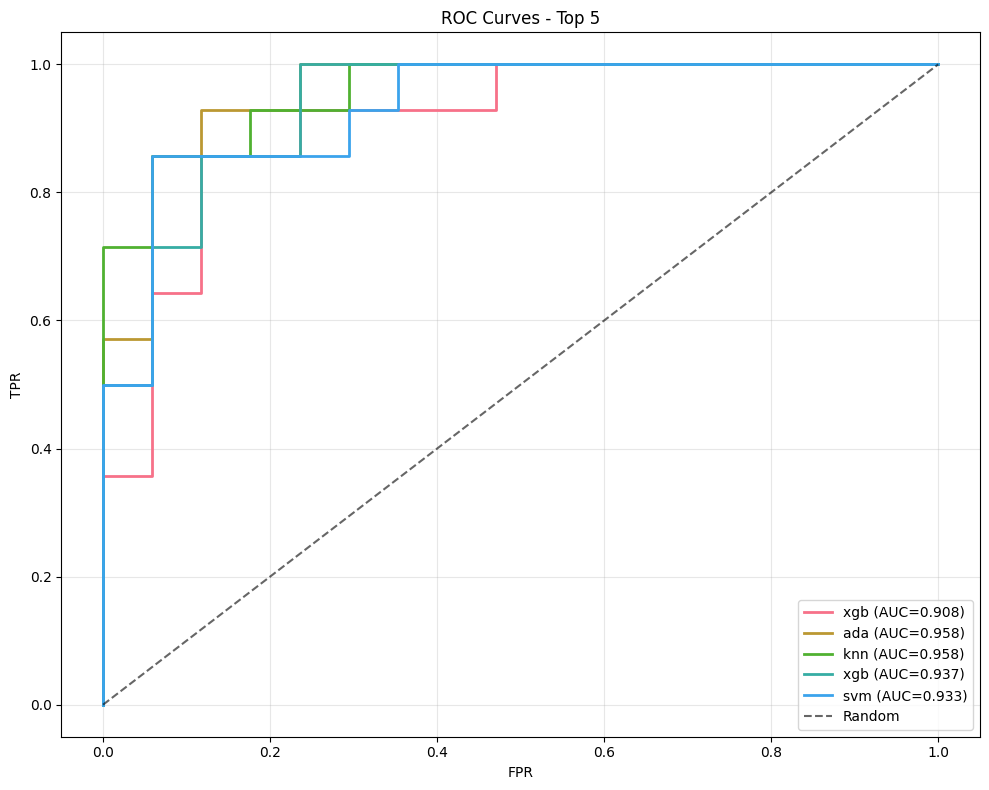

In [ ]:
# =================================================================================
# MAIN
# =================================================================================

if __name__ == "__main__":
    print("="*60)
    print("Building ONE dataset with engineered features + Boruta selection → master_boruta_*")
    try:
        builder = MasterBorutaBuilder(
            data_path="../data/processed/",
            k_keep_hint=13,
            corr_thresh=0.90,
            include_tentative=False,
            max_iter=200,
            alpha=0.05,
            random_state=RANDOM_STATE
        )
        if BORUTA_AVAILABLE:
            builder.build_and_save()
        else:
            print("Skipping Boruta build (package not installed).")
    except Exception as e:
        print(f"[WARN] Building master_boruta failed: {e}")

    print("\nRunning training on all datasets (with tuning)")
    pipe = HeartDiseasePipeline(data_path="../data/processed/", n_jobs=N_JOBS)
    pipe.run(
        datasets=('raw','fe','dt','fe_dt','master_boruta'),
        imbalance=('none','smote'),
        n_iter=50
    )

    if not pipe.summary_df.empty:
        print("\n" + "="*60)
        print("PIPELINE EXECUTION COMPLETED")
        print("="*60)
        best = pipe.summary_df.iloc[0]
        print(f"Best Configuration: {best['Configuration']}")
        print(f"F1 Score: {best['f1']:.4f}")
        print(f"Accuracy: {best['accuracy']:.4f}")
        print(f"AUC-ROC: {best.get('roc_auc', np.nan)}")

        total = len(pipe.results)
        succ = sum(1 for r in pipe.results.values() if r['status']=='success')
        print(f"\nTotal models trained: {total}")
        print(f"Successful: {succ} ({succ/total*100:.1f}%)")

        # Save best models & SHAP packs
        pipe.save_best_models(per_dataset=True, global_best=True)

        # Optional visuals
        create_visualizations(pipe)
        create_roc_comparison(pipe)


In [ ]:
# list available saved packs (global + per-dataset)

import json, glob, os
from pathlib import Path
from pprint import pprint

MODELS_DIR = Path("./models")
ARTIFACTS_DIR = Path("./artifacts")

def list_saved_packs():
    metas = sorted(MODELS_DIR.glob("*.json"))
    rows = []
    for m in metas:
        with open(m, "r") as f:
            meta = json.load(f)
        # derive tag
        tag = Path(meta["paths"]["model"]).stem
        rows.append({
            "tag": tag,
            "meta_path": str(m),
            "dataset": meta.get("dataset"),
            "imbalance": meta.get("imbalance"),
            "model": meta.get("model"),
        })
    return rows

packs = list_saved_packs()
print(f"Found {len(packs)} saved packs.")
pprint(packs[:10])  # peek first 10

# Helper: pick the latest 'global_best' by timestamp in the tag
def pick_latest_global_best():
    gb = [p for p in packs if p["tag"].startswith("global_best_")]
    if not gb: 
        return None
    # tags end with timestamp; sort by tag string
    return sorted(gb, key=lambda r: r["tag"])[-1]

latest_global = pick_latest_global_best()
print("\nLatest global best:")
pprint(latest_global)


Found 6 saved packs.
[{'dataset': 'dt',
  'imbalance': 'smote',
  'meta_path': 'models/dataset_best_dt_smote_ada_20250926_223355.json',
  'model': 'ada',
  'tag': 'dataset_best_dt_smote_ada_20250926_223355'},
 {'dataset': 'fe_dt',
  'imbalance': 'none',
  'meta_path': 'models/dataset_best_fe_dt_none_knn_20250926_223355.json',
  'model': 'knn',
  'tag': 'dataset_best_fe_dt_none_knn_20250926_223355'},
 {'dataset': 'fe',
  'imbalance': 'smote',
  'meta_path': 'models/dataset_best_fe_smote_xgb_20250926_223355.json',
  'model': 'xgb',
  'tag': 'dataset_best_fe_smote_xgb_20250926_223355'},
 {'dataset': 'master_boruta',
  'imbalance': 'none',
  'meta_path': 'models/dataset_best_master_boruta_none_ada_20250926_223356.json',
  'model': 'ada',
  'tag': 'dataset_best_master_boruta_none_ada_20250926_223356'},
 {'dataset': 'raw',
  'imbalance': 'none',
  'meta_path': 'models/dataset_best_raw_none_xgb_20250926_223355.json',
  'model': 'xgb',
  'tag': 'dataset_best_raw_none_xgb_20250926_223355'},
 {'

In [ ]:
# load one SHAP pack by meta path (or auto-pick the latest global_best)

from joblib import load
import pandas as pd
import numpy as np

def load_pack(meta_path: str=None, fallback_to_latest_global=True):
    if meta_path is None and fallback_to_latest_global:
        cand = pick_latest_global_best()
        if cand is None:
            raise FileNotFoundError("No saved packs found. Run training & save_best_models() first.")
        meta_path = cand["meta_path"]

    with open(meta_path, "r") as f:
        meta = json.load(f)

    model = load(meta["paths"]["model"])
    X_bg = pd.read_csv(meta["paths"]["X_background"])
    X_test = pd.read_csv(meta["paths"]["X_test"])
    y_test = pd.read_csv(meta["paths"]["y_test"])["target"]
    preds_path = meta["paths"].get("predictions")
    preds_df = pd.read_csv(preds_path) if preds_path and os.path.exists(preds_path) else None

    print(f"Loaded model: {meta['model']} | dataset={meta['dataset']} | imb={meta['imbalance']}")
    print(f"X_bg: {X_bg.shape} | X_test: {X_test.shape} | y_test: {y_test.shape}")
    return meta, model, X_bg, X_test, y_test, preds_df

meta, fitted_model, X_bg, X_test, y_test, preds_df = load_pack(meta_path=None)  # or pass a specific meta.json path


Loaded model: xgb | dataset=raw | imb=none
X_bg: (100, 13) | X_test: (31, 13) | y_test: (31,)


In [ ]:
import shap
import warnings
from sklearn.linear_model import LogisticRegression

def build_shap_explainer(model, X_background):
    name = type(model).__name__.lower()
    explainer = None

    try:
        # Tree models
        if any(k in name for k in ["randomforest", "xgb", "lgbm", "gradientboosting", "adaboost", "extratrees"]):
            explainer = shap.TreeExplainer(model)
        # Linear models
        elif isinstance(model, LogisticRegression):
            try:
                explainer = shap.LinearExplainer(model, X_background, feature_dependence="independent")
            except Exception:
                explainer = shap.LinearExplainer(model, X_background)
        # SVM / KNN / anything else → KernelExplainer (use small background)
        else:
            bg = X_background.sample(n=min(200, len(X_background)), random_state=0)
            explainer = shap.KernelExplainer(model.predict_proba, bg, link="logit")
        return explainer
    except Exception as e:
        warnings.warn(f"Falling back to KernelExplainer due to: {e}")
        bg = X_background.sample(n=min(200, len(X_background)), random_state=0)
        return shap.KernelExplainer(model.predict_proba, bg, link="logit")

explainer = build_shap_explainer(fitted_model, X_bg)
print("Explainer:", type(explainer).__name__)


Explainer: TreeExplainer


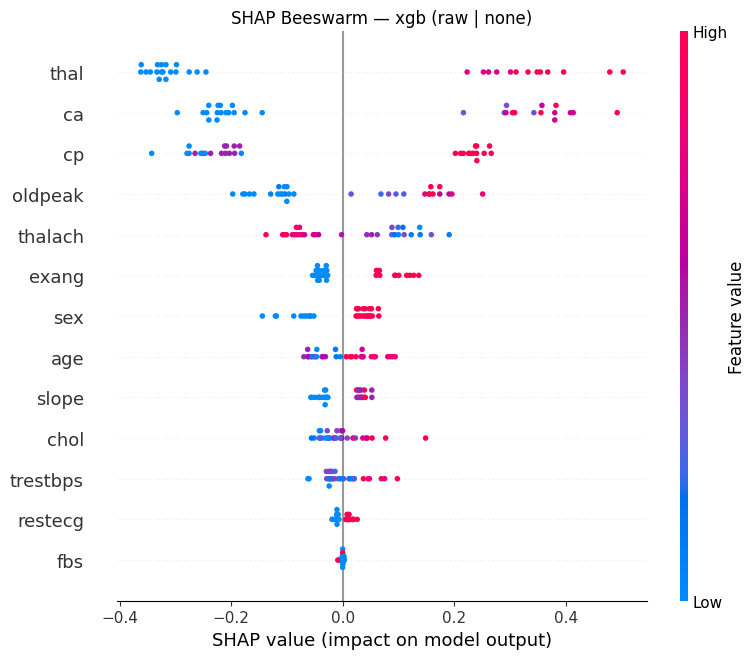

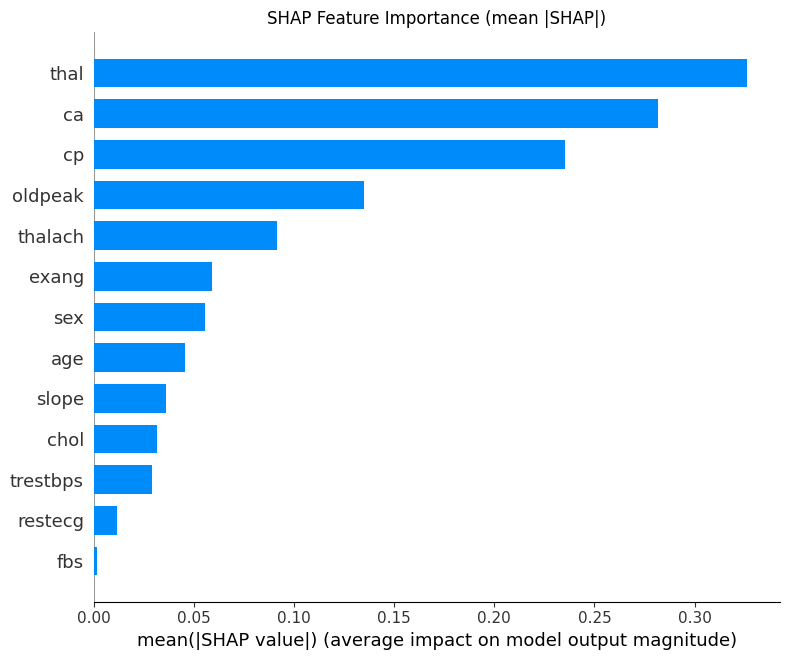

In [5]:
# CELL: SHAP summary plots (beeswarm + bar)

import matplotlib.pyplot as plt
import numpy as np

# Compute SHAP values on a manageable slice for speed, e.g., first 512 rows
X_slice = X_test.iloc[:min(512, len(X_test))].copy()

# For tree/linear: shap_values can be array or list (for multiclass). We need class-1 if binary.
shap_values = explainer.shap_values(X_slice)

# Handle shape for binary probabilistic models:
def pick_binary_class_shap(shap_values):
    if isinstance(shap_values, list) and len(shap_values) == 2:
        return shap_values[1]  # class 1
    return shap_values  # already array

sv_bin = pick_binary_class_shap(shap_values)

plt.figure(figsize=(9, 6))
shap.summary_plot(sv_bin, X_slice, show=False)
plt.title(f"SHAP Beeswarm — {meta['model']} ({meta['dataset']} | {meta['imbalance']})")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 6))
shap.summary_plot(sv_bin, X_slice, plot_type="bar", show=False, max_display=20)
plt.title("SHAP Feature Importance (mean |SHAP|)")
plt.tight_layout()
plt.show()


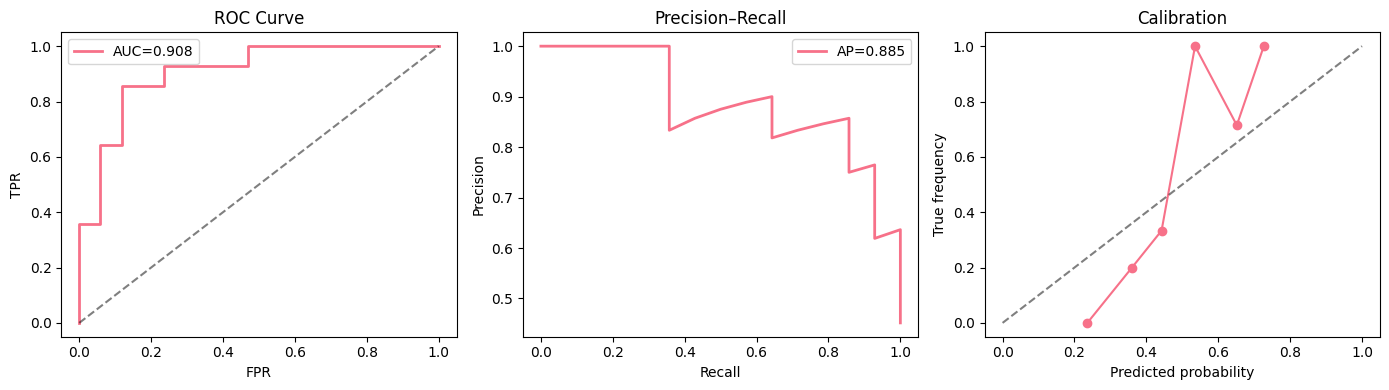

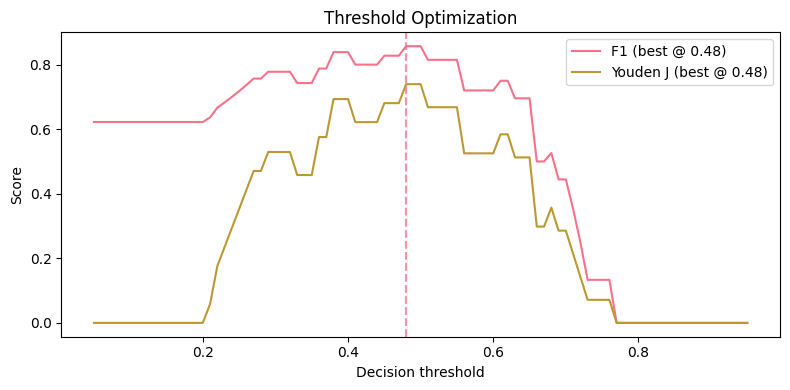

In [ ]:
# ROC, PR, Calibration, and Threshold Sweep

from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

# Ensure probabilities
if hasattr(fitted_model, "predict_proba"):
    y_proba = fitted_model.predict_proba(X_test)[:, 1]
elif hasattr(fitted_model, "decision_function"):
    # Min-max to [0,1] as a fallback
    scores = fitted_model.decision_function(X_test)
    smin, smax = scores.min(), scores.max()
    y_proba = (scores - smin) / (smax - smin + 1e-12)
else:
    y_proba = None

if y_proba is not None:
    # ROC
    fpr, tpr, thr = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    # PR
    prec, rec, thr_pr = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(rec, prec)

    # Calibration
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy="uniform")

    # Plots
    plt.figure(figsize=(14,4))

    plt.subplot(1,3,1)
    plt.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc:.3f}")
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()

    plt.subplot(1,3,2)
    plt.plot(rec, prec, lw=2, label=f"AP={pr_auc:.3f}")
    plt.title("Precision–Recall"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()

    plt.subplot(1,3,3)
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1],'k--',alpha=0.5)
    plt.title("Calibration"); plt.xlabel("Predicted probability"); plt.ylabel("True frequency")

    plt.tight_layout(); plt.show()

    # Threshold sweep for F1 and Youden's J
    grid = np.linspace(0.05, 0.95, 91)
    f1s, youdens = [], []
    for t in grid:
        yp = (y_proba >= t).astype(int)
        tp = np.sum((yp==1)&(y_test==1))
        fp = np.sum((yp==1)&(y_test==0))
        fn = np.sum((yp==0)&(y_test==1))
        tn = np.sum((yp==0)&(y_test==0))
        prec_ = tp/(tp+fp) if (tp+fp)>0 else 0
        rec_  = tp/(tp+fn) if (tp+fn)>0 else 0
        f1s.append( (2*prec_*rec_ / (prec_+rec_)) if (prec_+rec_)>0 else 0 )
        sens = rec_
        spec = tn/(tn+fp) if (tn+fp)>0 else 0
        youdens.append(sens + spec - 1)

    t_f1 = grid[int(np.argmax(f1s))]
    t_yj = grid[int(np.argmax(youdens))]

    plt.figure(figsize=(8,4))
    plt.plot(grid, f1s, label=f"F1 (best @ {t_f1:.2f})")
    plt.plot(grid, youdens, label=f"Youden J (best @ {t_yj:.2f})")
    plt.axvline(t_f1, ls='--', alpha=0.5)
    plt.axvline(t_yj, ls='--', alpha=0.5)
    plt.xlabel("Decision threshold"); plt.ylabel("Score")
    plt.title("Threshold Optimization")
    plt.legend(); plt.tight_layout(); plt.show()

else:
    print("Model doesn't expose probabilities; skip ROC/PR/Calibration/threshold plots.")


Threshold=0.48
Confusion Matrix:
 [[15  2]
 [ 2 12]]

Report at optimal threshold:

              precision    recall  f1-score   support

           0      0.882     0.882     0.882        17
           1      0.857     0.857     0.857        14

    accuracy                          0.871        31
   macro avg      0.870     0.870     0.870        31
weighted avg      0.871     0.871     0.871        31



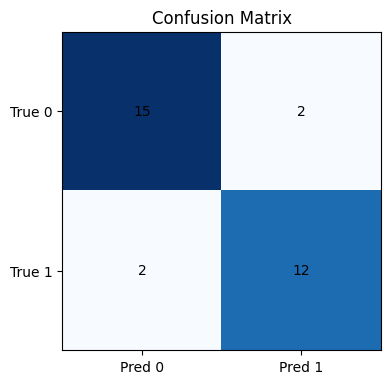

In [ ]:
# confusion matrix & simple report at chosen threshold

from sklearn.metrics import confusion_matrix, classification_report

if y_proba is not None:
    threshold = t_f1  # or t_yj
    y_pred_opt = (y_proba >= threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred_opt)
    tn, fp, fn, tp = cm.ravel()
    print(f"Threshold={threshold:.2f}")
    print("Confusion Matrix:\n", cm)
    print("\nReport at optimal threshold:\n")
    print(classification_report(y_test, y_pred_opt, digits=3))

    # Quick matrix plot
    plt.figure(figsize=(4,4))
    plt.imshow(cm, cmap='Blues')
    plt.title("Confusion Matrix")
    plt.xticks([0,1], ["Pred 0", "Pred 1"])
    plt.yticks([0,1], ["True 0", "True 1"])
    for (i,j), val in np.ndenumerate(cm):
        plt.text(j, i, f"{val}", ha='center', va='center')
    plt.tight_layout(); plt.show()
else:
    print("No probabilities available for thresholded confusion matrix.")
